### Use Case 2: Particles

In this example we will subsample a dataset stored on SciServer using trajectories of synthetic Lagrangian particles.
OceanSpy enables the extraction of properties at any given location, but it does not have Lagrangian capabilities yet.
The trajectories used in this notebook have been previously computed using a Matlab-based Lagrangian particle code ([Gelderloos et al., 2016](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7870923)). The Lagrangian particle code, along with synthetic oceanographic observational platforms (such as Argo floats, isobaric floats, current profiler, and gliders), will be incorporated into OceanSpy in future releases.

The animation below shows the change in temperature of synthetic particles along their trajectories. Particles have been released in Denmark Strait and tracked backward in time from day 0 to day 180, and tracked forward in time from day 180 to 360. All particles are animated forward in time. Source: [https://player.vimeo.com/video/296949375](https://player.vimeo.com/video/296949375)

In [1]:
# Display animation
from IPython.display import HTML

# Link
s = 'https://player.vimeo.com/video/296949375'

# Options
w = 640
h = 360
f = 0
a = 'autoplay; fullscreen'

# Display
HTML(f'<iframe src="{s}"'
     'width="640" height="360" frameborder="0" allow="autoplay; fullscreen"'
     'allowfullscreen></iframe>')

/home/idies/miniconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


The subsampling method used in this notebook resembles Lagrangian floats deployed by observational oceanographers, such as RAFOS floats. They are acoustically tracked floats able to measure water properties and provide accurate trajectories in both the horizontal and vertical dimensions. The following picture shows the deployment of a RAFOS float during the Overturning in the Subpolar North Atlantic Program (OSNAP). Source: [www.o-snap.org](https://www.o-snap.org/)  
![RAFOS](https://www.o-snap.org/wp-content/uploads/2016/08/160801_deploying_a_RAFOS_float-1-1024x768.jpg)

## Extract
The time needed to extract particle properties depends on the number of particles, length of the trajectories, number of variables requested, and more importantly how far the particles travel in the domain and therefore, how dispersed the Lagrangian trajectories are.
Thus, it is preferable to extract particle properties asynchronously using the Job mode of SciServer compute (see [SciServer access](sciserver.rst#sciserver-access) for step-by-step instructions).
This notebook, when executed in interactive mode, will skip the subsampling step. Instead, it will load an `OceanDataset` previously created executing the same notebook in Job mode. 

Set `interactive = True` to run in Interactive mode, or `interactive = False` to run in Job mode.
Alternatively, you can activate the Job mode by typing `interactive = False` in the **Parameters** slot of the SciServer Job submission form.

In [2]:
interactive = True # True: Interactive - False: Job

# Check parameters.txt
try:
    # Use values from parameters.txt
    f = open('parameters.txt', 'r')
    for line in f:
        exec(line)
    f.close()
except FileNotFoundError:
    # Keep preset values
    pass
        
# Setup environment
if interactive:
    pass
else:
    import sys
    !conda install --yes --prefix {sys.prefix} dask distributed bottleneck netCDF4 xarray cartopy esmpy ffmpeg intake-xarray tqdm geopy xgcm xesmf
    !{sys.executable} -m pip install --upgrade xmitgcm
    !{sys.executable} -m pip install --upgrade git+https://github.com/malmans2/oceanspy.git

In [3]:
# Start Client
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:36607 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 257.77 GB


In [4]:
# Import OceanSpy
import oceanspy as ospy

# Additional imports
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from cartopy.crs import PlateCarree

Here we open the `OceanDataset` containing the Eulerian fields.
Then, for plotting purposes, we  mask out the land from the bathymetry (variable `Depth`) and merge the variable `masked_Depth` into the `OceanDataset`.

In [5]:
# Open OceanDataset (eulerian fields)
od_eul = ospy.open_oceandataset.from_catalog('EGshelfIIseas2km_ASR_full')

# Mask depth for plotting purposes
Depth = od_eul.dataset['Depth']
Depth = Depth.where(Depth>0)
od_eul = od_eul.merge_into_oceandataset(Depth.rename('masked_Depth'))

Opening EGshelfIIseas2km_ASR_full.


/home/idies/miniconda3/lib/python3.7/site-packages/dask/array/blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


High-resolution (~2km) numerical simulation covering the east Greenland shelf (EGshelf), 
and the Iceland and Irminger Seas (IIseas) forced by the Arctic System Reanalysis (ASR). 
Citation:
 * Almansi et al., 2017 - JPO.
Characteristics:
 * full: Full domain without variables to close budgets.
See also:
 * EGshelfIIseas2km_ASR_crop: Cropped domain with variables to close budgets.


We will analyze about 4,000 synthetic particles released in Denmark Strait at the end of February, and tracked forward in time for 30 days (6 hour resolution).
The following properties will be extracted: temperature, salinity, ocean depth, and vertical component of relative vorticity. Note that OceanSpy allows to extract any property, and variables such as `momVort3` that are not in the model cell centers can be subsampled.  

In [6]:
import os
import subprocess

# Create or download OceanDataset with particle properties
mat_name = 'oceanspy_particle_trajectories.mat' # Used by Job
nc_name = 'oceanspy_particle_properties.nc' # Created by Job
if interactive:
    # Download OceanDataset
    if not os.path.isdir(mat_name):
        import subprocess
        print(f"Downloading [{nc_name}].")
        commands = [f'wget -v -O {nc_name} -L '
                    'https://jh.box.com/shared/static/'
                    'ibh1yqmwjts356jcb61k6cuzujqcabk6.nc']
        subprocess.call('&&'.join(commands), shell=True)
else:
    # Download trajectories
    if not os.path.isdir(mat_name):
        import subprocess
        print(f"Downloading [{mat_name}].")
        commands = [f'wget -v -O {mat_name} -L '
                    'https://jh.box.com/shared/static/'
                    '3lh0v823867xfz7x0pfq3v6n7h5kg7g6.mat']
        subprocess.call('&&'.join(commands), shell=True)

    # Read trajectories
    import scipy.io as sio
    particle_data = sio.loadmat(mat_name)

    # Get time
    import numpy as np
    time_origin = np.datetime64('2008-02-29T00:00')
    times = np.asarray([time_origin + np.timedelta64(int(dt*24), 'h')
                        for dt in particle_data['timee'].squeeze()])

    # Get trajectories
    Xpart = particle_data['f_lons'].transpose()
    Ypart = particle_data['f_lats'].transpose()
    Zpart = particle_data['f_deps'].transpose()

    # Pick variables (velocities and hydrography)
    varList = ['Temp', 'S', 'momVort3', 'Depth']

    # Extract properties 
    od_lag = ospy.subsample.particle_properties(od_euler,
                                                 times = times,
                                                 Ypart = Ypart,
                                                 Xpart = Xpart,
                                                 Zpart = Zpart,
                                                 varList = varList)

    # Save in netCDF format
    od_lag.to_netcdf(nc_name)
    
# Open OceanDataset
od_lag = ospy.open_oceandataset.from_netcdf(nc_name)

Opening dataset from [oceanspy_particle_properties.nc].


The OceanDataset created by `extract_properties` has 3 dimensions:

* `particle`: Every particle is associated with an ID (integer number).
* `time`: All the available snapshots (in this case, from Feb. 29th to Mar. 30th with 6-hour resolution).
* `time_midp`: Mid-points of the time dimension. For example, this is the dimension associated with gradients computed along the time axis.

In [7]:
print(od_lag.dataset)

<xarray.Dataset>
Dimensions:    (particle: 3954, time: 121, time_midp: 120)
Coordinates:
  * particle   (particle) int64 0 1 2 3 4 5 6 ... 3948 3949 3950 3951 3952 3953
  * time       (time) datetime64[ns] 2008-02-29 ... 2008-03-30
  * time_midp  (time_midp) datetime64[ns] 2008-02-29T03:00:00 ... 2008-03-29T21:00:00
Data variables:
    XC         (time, particle) float64 ...
    YC         (time, particle) float64 ...
    Z          (time, particle) float64 ...
    Zl         (time, particle) float64 ...
    Zp1        (time, particle) float64 ...
    Zu         (time, particle) float64 ...
    XG         (time, particle) float64 ...
    YG         (time, particle) float64 ...
    Depth      (time, particle) float64 ...
    Temp       (time, particle) float64 ...
    S          (time, particle) float64 ...
    momVort3   (time, particle) float64 ...
Attributes:
    OceanSpy_grid_coords:  {'time': {'time': -0.5, 'time_midp': None}}


## Compute

We can now use `ospy.compute` functions on the extracted particle properties.
For example, here we compute potential density anomalies using temperature and salinity.

In [8]:
od_lag = od_lag.compute.potential_density_anomaly()
print(od_lag.dataset['Sigma0'])

Computing potential density anomaly using the following parameters: {'eq_state': 'jmd95'}.
<xarray.DataArray 'Sigma0' (time: 121, particle: 3954)>
array([[28.064481, 28.064481, 28.061507, ..., 27.607976, 27.772043, 27.828748],
       [28.067225, 28.064161, 28.064161, ..., 27.620176, 27.755399, 27.827409],
       [28.067963, 28.067963, 28.067963, ..., 27.600384, 27.737466, 27.823059],
       ...,
       [27.971674, 27.88427 , 27.814402, ..., 27.613081, 27.61246 , 27.80289 ],
       [27.97205 , 27.874295, 27.813345, ..., 27.629291, 27.629971, 27.802467],
       [27.972959, 27.869781, 27.814992, ..., 27.630082, 27.651605, 27.80404 ]])
Coordinates:
  * particle  (particle) int64 0 1 2 3 4 5 6 ... 3948 3949 3950 3951 3952 3953
  * time      (time) datetime64[ns] 2008-02-29 ... 2008-03-30
Attributes:
    units:                kg/m^3
    long_name:            potential density anomaly
    OceanSpy_parameters:  {'eq_state': 'jmd95'}


Here we compute gradients along the time dimension for each variable previously extracted:

In [9]:
od_lag = od_lag.compute.gradient()
print(od_lag.dataset)

Computing gradient.
<xarray.Dataset>
Dimensions:          (particle: 3954, time: 121, time_midp: 120)
Coordinates:
  * particle         (particle) int64 0 1 2 3 4 5 ... 3949 3950 3951 3952 3953
  * time_midp        (time_midp) datetime64[ns] 2008-02-29T03:00:00 ... 2008-03-29T21:00:00
  * time             (time) datetime64[ns] 2008-02-29 ... 2008-03-30
Data variables:
    XC               (time, particle) float64 ...
    YC               (time, particle) float64 ...
    Z                (time, particle) float64 ...
    Zl               (time, particle) float64 ...
    Zp1              (time, particle) float64 ...
    Zu               (time, particle) float64 ...
    XG               (time, particle) float64 ...
    YG               (time, particle) float64 ...
    Depth            (time, particle) float64 ...
    Temp             (time, particle) float64 2.098 2.098 1.979 ... 1.123 2.757
    S                (time, particle) float64 35.13 35.13 35.11 ... 34.52 34.87
    momVort3       

## Mask and Split
Now we focus on particles carried by the dense overflow water, which is defined as water with $\sigma_{0}\geq$ 27.8 kg m$^{-3}$.

First, we separate all particles seeded in the overflow. Then, we split these particles in two `OceanDataset` using the following criteria:

1. `od_dense`: $\sigma_0$ along the path is always greater than 27.8 kg m$^{-3}$.
2. `od_mixed`: $\sigma_0$ at the last snapshot is lower than 27.8 kg m$^{-3}$, and at least 50% of the snapshots have $\sigma_0<$ 27.8 kg m$^{-3}$.

In [10]:
# Overflow mask
DSO_threshold = 27.8 # kg/m^3
mask_DSO = xr.where(od_lag.dataset['Sigma0'] >= DSO_threshold, 1, 0)

# Mask particles always in the overflow
mask_dense = xr.where(mask_DSO.sum('time') == len(od_lag.dataset['time']), 1, 0)

# Mask mixed particles
mask_mixed = xr.where(np.logical_and(np.logical_and(mask_DSO.isel(time=0) == 1,
                                                    mask_DSO.isel(time=-1) == 0,),
                                     mask_DSO.sum('time') <= len(od_lag.dataset['time'])/2), 1, 0)

# Create OceanDataset
od_dense = ospy.OceanDataset(od_lag.dataset.where(mask_dense, drop=True))
od_mixed = ospy.OceanDataset(od_lag.dataset.where(mask_mixed, drop=True))

Here we plot the trajectories on top of projected maps:

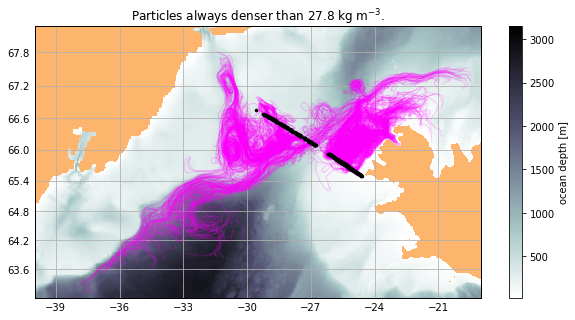

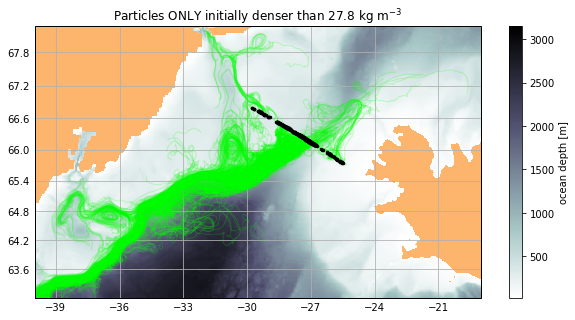

In [11]:
ods = [od_dense, od_mixed]
colors = ['fuchsia', 'lime']
titles = [r'Particles always denser than 27.8 kg m$^{-3}$.',
          r'Particles ONLY initially denser than 27.8 kg m$^{-3}$']
for _, (od_i, col, tit) in enumerate(zip(ods, colors, titles)):
    
    # Plot Depth
    fig = plt.figure(figsize=(10, 5))
    ax = od_eul.plot.horizontal_section(varName='masked_Depth', cmap='bone_r')
    land_col = (253/255, 180/255, 108/255)
    ax.background_patch.set_facecolor(land_col)
    ax.set_extent([-40, -19, 63, 68])
    
    # Plot trajectories
    ax.plot(od_i.dataset['XC'],
            od_i.dataset['YC'],
            color=col, alpha=0.2, linewidth=1,
            transform=PlateCarree())
    
    # Plot initial positions
    ax.plot(od_i.dataset['XC'].isel(time=0),
            od_i.dataset['YC'].isel(time=0),
            'k.', markersize=5,
            transform=PlateCarree())
    
    # Title
    _ = ax.set_title(tit)
    plt.show()

## TS-diagrams
We can use TS-diagrams to investigate the hydrography of `od_dense` and `od_mixed`.
For example, here we plot the oceandatasets color-coded by particle depths separately (subplots a and b), then we plot them together on the same isopycnal contours (subplot c).

Isopycnals: Computing potential density anomaly using the following parameters: {'eq_state': 'jmd95'}.
Isopycnals: Computing potential density anomaly using the following parameters: {'eq_state': 'jmd95'}.
Isopycnals: Computing potential density anomaly using the following parameters: {'eq_state': 'jmd95'}.
Isopycnals: Computing potential density anomaly using the following parameters: {'eq_state': 'jmd95'}.


/home/idies/miniconda3/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


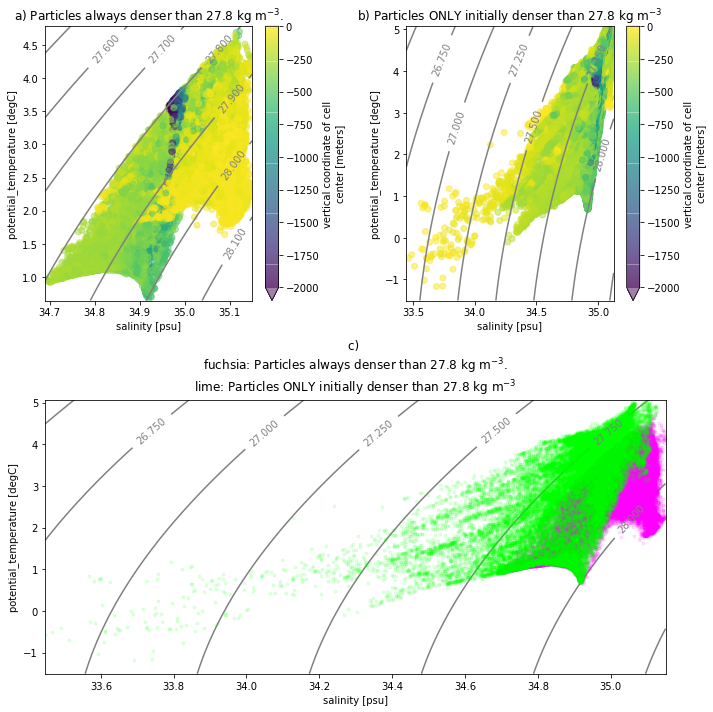

In [12]:
fig = plt.figure(figsize=(10, 10))

for i, (od_i, col, tit) in enumerate(zip(ods, colors, titles)):
    plt.subplot(int('22'+str(i+1)))
    ax = od_i.plot.TS_diagram(colorName='Z', alpha=0.5,
                              cmap_kwargs={'vmin': -2000, 'vmax': 0})
    ax.set_title(chr(ord('a') + i)+') '+tit)

plt.subplot(212)
Tlim = [min([od_i.dataset['Temp'].min().values for od_i in ods]),
        max([od_i.dataset['Temp'].max().values for od_i in ods])]
Slim = [min([od_i.dataset['S'].min().values for od_i in ods]),
        max([od_i.dataset['S'].max().values for od_i in ods])]
for i, (od_i, col, tit) in enumerate(zip(ods, colors, titles)):
    contour_kwargs={}
    if i==0:
        contour_kwargs['levels'] =[]
    ax = od_i.plot.TS_diagram(color=col,
                              alpha=0.1,
                              Tlim=Tlim,
                              Slim=Slim,
                              contour_kwargs=contour_kwargs)
tit = '\n'.join(['c) ']+[f'{col}: {tit}' for _, (col, tit) in enumerate(zip(colors, titles))])
ax.set_title(tit)

plt.tight_layout()

## Time series
Now, we select 5 particles that were seeded in the overflow and became less dense along the path.

In [13]:
nparts = 5
step = np.ceil(len(od_mixed.dataset['particle'])/5)
od_5parts = ospy.OceanDataset(od_mixed.dataset.isel(particle=slice(None, None, int(step))))

Here is a plot of their trajectories:

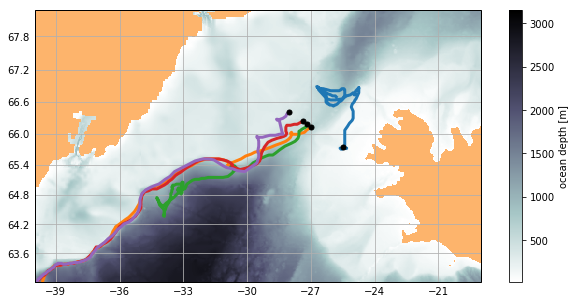

In [14]:
ods = [od_dense, od_mixed]
colors = ['fuchsia', 'lime']
titles = [r'Particles always denser than 27.8 kg m$^{-3}$.',
          r'Particles ONLY initially denser than 27.8 kg m$^{-3}$']

# Plot Depth
fig = plt.figure(figsize=(10, 5))
ax = od_eul.plot.horizontal_section(varName='masked_Depth', cmap='bone_r')
land_col = (253/255, 180/255, 108/255)
ax.background_patch.set_facecolor(land_col)
ax.set_extent([-40, -19, 63, 68])

# Plot trajectories
traj = ax.plot(od_5parts.dataset['XC'],
               od_5parts.dataset['YC'],
               linewidth=3,
               transform=PlateCarree())

# Plot initial positions
i_pos = ax.plot(od_5parts.dataset['XC'].isel(time=0),
                od_5parts.dataset['YC'].isel(time=0),
                'k.', markersize=10,
                transform=PlateCarree())

Here we plot the change in potential density anomaly along the path, and the potential density anomaly gradient along the time axis.

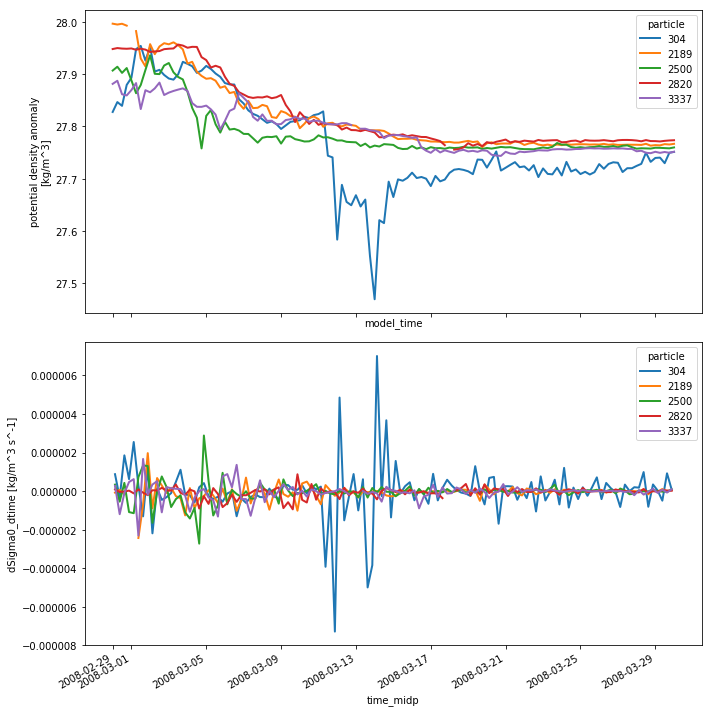

In [15]:
varName = 'Sigma0'
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
for i, ax in enumerate(axes.flatten()):
    if i==1:
        varName = f'd{varName}_dtime'
    ax = od_5parts.plot.time_series(varName=varName, ax=ax, linewidth=2)

The plots above can be easily reproduced for any of the extracted variables. 
For example, try to change `varName = 'Sigma0'` in the cell above with any of the variables printed below.

In [16]:
# Create table
table = {var: od_5parts.dataset[var].attrs.pop('description',
                                               od_5parts.dataset[var].attrs.pop('long_name', None))
         for var in od_5parts.dataset.variables
         if 'time' not in var and 'particle' not in var}
print("\n{:>15}: {}\n".format('varName', 'DESCRIPTION'))
for name, desc in sorted(table.items()):
    print("{:>15}: {}".format(name, desc))


        varName: DESCRIPTION

          Depth: fluid thickness in r coordinates (at rest)
              S: salinity
         Sigma0: potential density anomaly
           Temp: potential_temperature
             XC: X coordinate of cell center (T-P point)
             XG: X coordinate of cell corner (Vorticity point)
             YC: Y coordinate of cell center (T-P point)
             YG: Y coordinate of cell corner (Vorticity point)
              Z: vertical coordinate of cell center
             Zl: vertical coordinate of upper cell interface
            Zp1: vertical coordinate of cell interface
             Zu: vertical coordinate of lower cell interface
       momVort3: 3rd component (vertical) of Vorticity
